# Example to show how to transform the coordinate system of the SLM and translation stage to the world coordinate system.

This code uses the allignment procedure as described in the supplementary material of https://doi.org/10.1364/OL.400985.

So far only assuming planar geometries without any distortions like barrel and pincussion. and assuming stage and SLM respond in a linear way to the inputs.

In [1]:
# Load the necessary functions
from openwfs.utilities.utilities import Transformation_Matrix_SLM_and_stage_to_World_Coordinates
import numpy as np
import astropy.units as u
from openwfs.simulation import Microscope, StaticSource, Camera, SLM
import matplotlib.pyplot as plt
from openwfs.plot_utilities import grab_and_show

ImportError: cannot import name 'Transformation_Matrix_SLM_to_World_Coordinates' from 'openwfs.utilities.utilities' (C:\Users\ABAB\Documents\OpenWFS\openwfs\openwfs\utilities\utilities.py)

In [75]:
# Specifiy the parameters for the sample and microscope
specimen_resolution = (256, 256)    # height × width in pixels of the specimen image
specimen_pixel_size = 60 * u.nm     # resolution (pixel size) of the specimen image
magnification = 40                  # magnification from object plane to camera.
numerical_aperture = 0.85           # numerical aperture of the microscope objective
wavelength = 532.8 * u.nm           # wavelength of the light, for computing diffraction.

In [76]:
# Create a random noise image with a few bright spots
src = StaticSource(
    data=np.maximum(np.random.randint(-10000, 100, specimen_resolution, dtype=np.int16), 0),
    pixel_size=specimen_pixel_size,
)

# Create a microscope with the given parameters
mic = Microscope(
    src,
    magnification=magnification,
    numerical_aperture=numerical_aperture,
    wavelength=wavelength,
)

# simulate shot noise in an 8-bit camera with auto-exposure:
cam = Camera(
    mic,
    analog_max=None,
    shot_noise=True,
    digital_max=255,
)
devices = {"camera": cam, "stage": mic.xy_stage}


# Allignment Procedure:
- Start with stage at (0,0)
- Take an image (im1)
- Move stage in x direction by a known amount (e.g. 7 um)
- Take an image (im2)
- Move stage back to (0,0)
- Take an image (im3)
- Move stage in y direction by the same known amount (e.g. 7 um)
- Take an image (im4)
- Do the same for applying a gradient to the SLM, instead of moving the stage.
- This will give you 4 images with known displacements in stage coordinates and 4 images with known displacements in SLM coordinates.

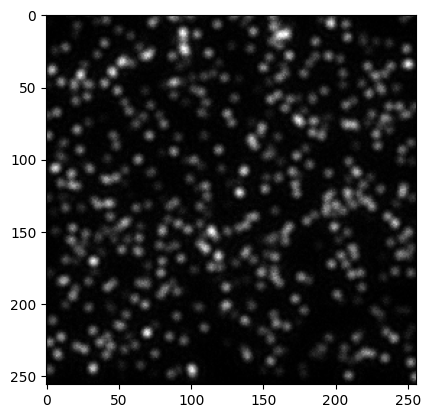

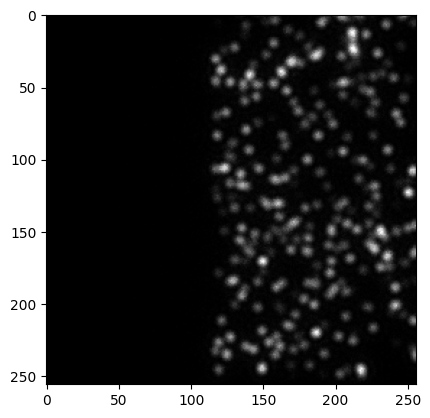

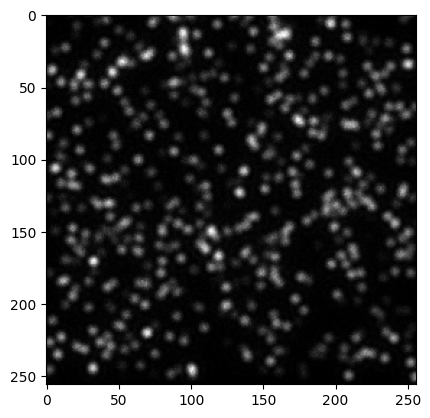

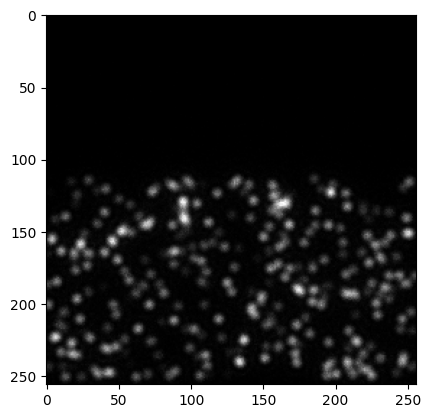

(256, 256, 8)

In [84]:
stage_displacement = 7                 # Known displacement of the stage in micrometers    
# SLM_displacement = stage_displacement

# Move stage to (0,0)
mic.xy_stage.x = 0 * 1 * u.um
mic.xy_stage.y = 0 * 1 * u.um

im1 = cam.read()
plt.imshow(im1, cmap='gray') 
plt.show()
mic.xy_stage.x = stage_displacement * 1 * u.um

im2 = cam.read()

plt.imshow(im2, cmap='gray') 
plt.show()

mic.xy_stage.x = 0 * 1 * u.um
mic.xy_stage.y = 0 * 1 * u.um

im3 = cam.read()

plt.imshow(im3, cmap='gray') 
plt.show()

mic.xy_stage.y = stage_displacement * 1 * u.um

im4 = cam.read()

plt.imshow(im4, cmap='gray') 
plt.show()

# data = np.stack([im1, im2, im3, im4, im1, im2, im3, im4], axis=2)  # shape: (8, height, width), For now assume the SLM and stage displacements have the same effect
data.shape

# Next, perform a similar procedure for the SLM, by applying gradients 
(gradient on the SLM corresponds to a shift of the image.)

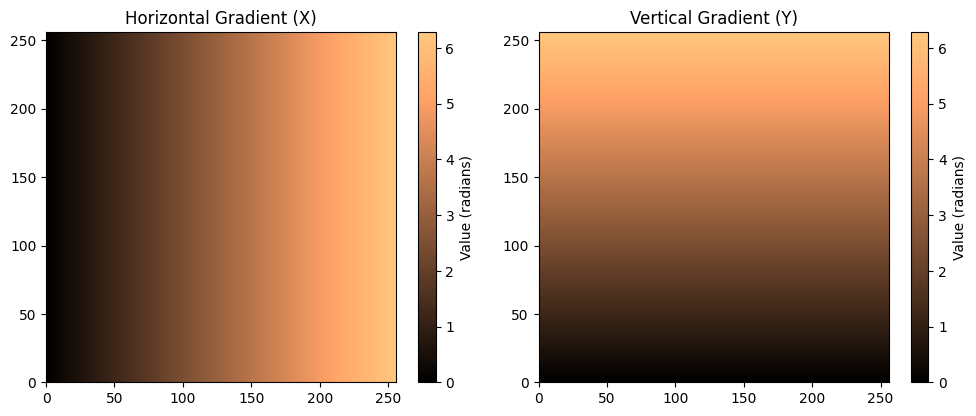

In [87]:
import numpy as np
import matplotlib.pyplot as plt

# reset stage position
mic.xy_stage.x = 0 * 1 * u.um
mic.xy_stage.y = 0 * 1 * u.um

# Define array size and range
size = 256
start = 0
end = np.pi*2
SLM_gradient = end - start

# Create 1D linear gradient
x = np.linspace(start, end, size)
y = np.linspace(start, end, size)

# Create 2D grid
X, Y = np.meshgrid(x, y, indexing='ij')

# Choose the gradient direction
gradient_x = Y  # horizontal gradient
gradient_y = X  # vertical gradient
# gradient = (X + Y)/2  # diagonal gradient

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First subplot: horizontal gradient
im1 = axes[0].imshow(gradient_x, origin='lower', cmap='copper', extent=[0, size, 0, size])
fig.colorbar(im1, ax=axes[0], label='Value (radians)')
axes[0].set_title("Horizontal Gradient (X)")

# Second subplot: vertical gradient
im2 = axes[1].imshow(gradient_y, origin='lower', cmap='copper', extent=[0, size, 0, size])
fig.colorbar(im2, ax=axes[1], label='Value (radians)')
axes[1].set_title("Vertical Gradient (Y)")

plt.tight_layout()
plt.show()

In [81]:
# Create a microscope with the given parameters
# mic = Microscope(
#     src,
#     magnification=magnification,
#     numerical_aperture=numerical_aperture,
#     wavelength=wavelength,
#     aberrations=gradient*30,
#     incident_field=gradient*30*1j
# )

from openwfs.utilities.patterns import gaussian,tilt

slm = SLM(shape=(256, 256))
# slm = SLM(shape=(256, 256), field_amplitude=gradient*30*1j*256)
#slm = SLM(shape=(256, 256), field_amplitude = tilt((256,256),g=0))
#slm = SLM(shape=(256, 256), field_amplitude=gaussian((256, 256), waist=1.0))
# waarom doet field_amplitude gradient niets???

# SLM_pattern = StaticSource(
#     data=gradient*30*1j,
#     pixel_size=specimen_pixel_size,
# )

mic = Microscope(
    src,
    magnification=magnification,
    numerical_aperture=numerical_aperture,
    wavelength=wavelength,
    # aberrations=gradient*30,
    incident_field=slm.field
)

# simulate shot noise in an 8-bit camera with auto-exposure:
cam = Camera(
    mic,
    analog_max=None,
    shot_noise=True,
    digital_max=255,
)

# Bug: Circular boundary conditions are used!!! 

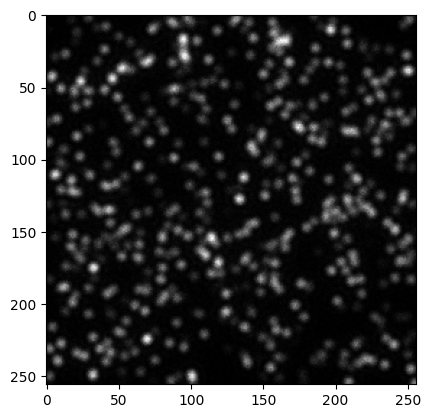

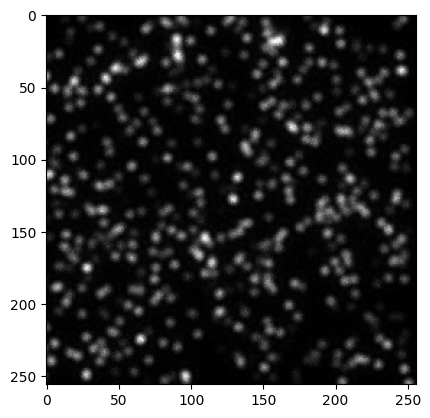

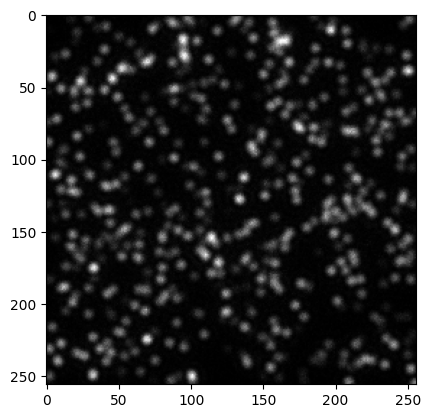

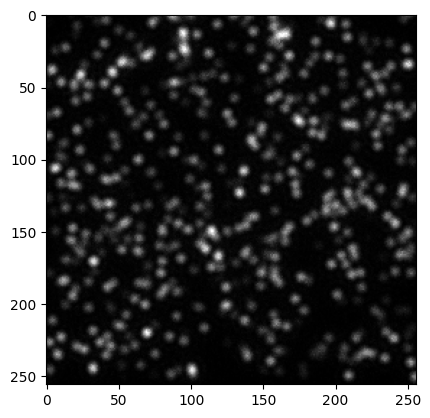

(256, 256, 8)

In [85]:
# reset stage position
mic.xy_stage.x = 0 * 1 * u.um
mic.xy_stage.y = 0 * 1 * u.um

slm.set_phases(0.*gradient_x)

im5 = cam.read()

plt.imshow(im5, cmap='gray') 
plt.show()

slm.set_phases(gradient_x)  # horizontal gradient

im6 = cam.read()
plt.imshow(im6, cmap='gray') 
plt.show()

slm.set_phases(0.*gradient_x)

im7 = cam.read()

plt.imshow(im7, cmap='gray') 
plt.show()


slm.set_phases(gradient_y)  # horizontal gradient
im8 = cam.read()

plt.imshow(im8, cmap='gray') 
plt.show()

data = np.stack([im1, im2, im3, im4, im5, im6, im7, im8], axis=2)  # shape: (8, height, width), For now assume the SLM and stage displacements have the same effect
data.shape

In [88]:
# Compute the transformation matrix as defined in https://doi.org/10.1364/OL.400985 (supplementary material)
Transformation_Matrix_SLM_to_World_Coordinates(data, stage_disp_xy_um = stage_displacement, SLM_grad_xy = SLM_gradient)

(array([[16.71428571,  0.        ],
        [ 0.        , 16.71428571]]),
 array([[-0.63661977,  0.        ],
        [ 0.        , -0.63661977]]))

In [6]:
# Some Errors/Bugs:

#Speciment pixel size lijkt eerder specimen size te definieren dan echt de pixel size???
#Vergroting microscoop lijkt niets te doen, camera resolutie en pixel grootte worden helemaal niet gebruikt, maar wel gedifinieerd in alle voorbeelden. Moet misschien ooit nog toegevoegd worden aan de mock devices. 

#The following combination of parameters throws an error after showing the image two cells below, but not a clear error about maximum NA, maybe add this?

# specimen_resolution = (64, 64)  # height × width in pixels of the specimen image
# specimen_pixel_size = 60 * u.nm  # resolution (pixel size) of the specimen image
# magnification = 40  # magnification from object plane to camera.
# numerical_aperture = 0.85*10  # numerical aperture of the microscope objective
# wavelength = 532.8 * u.nm  # wavelength of the light, for computing diffraction.